In [1]:
%load_ext autoreload
%autoreload 2

from bandit_monte_carlo import (
    monte_carlo_ep_greedy,
    final_estimates,
    plot_final_estimates,
    plot_q_convergence
)

# Question 1
### How do different training parameters affect convergence behavior in multi-armed bandit problem?

In order to investigate this question, we are going to break down our research into two steps:
a). Visualize the convergence behavior for one training of each parameter set
b). Average 1,000 trainings to see which parameters perform the best in i) yielding the maximum reward and ii) selecting the correct best arm

We are going to use the rewards probabilities of 20%, 50% and 80% for the three machines, use 1000 episodes, and try epsilon values of 0.2, 0.1, and 0.02.

(While Episodes can be modified, I would like to keep them constant for this experiment as I want to level the playing field for the different epsilon values to test which is the best. It's like each agent has a limited amount to spend on slot machines. If Episodes were to be increased, approximated Q-values would likely converge closer to their true counterparts, as more time would be spent sampling all the machines. If Episodes were decreased to a low zone where training might not sample the machines enough to choose correct arms would, there be a large behavior change.)

In [12]:
params_1 = {
    'true_rewards' : [0.2, 0.5, 0.8],
    'num_episodes': 1000,
    'epsilon': 0.2,
}
params_2 = {
    'true_rewards': [0.2, 0.5, 0.8],
    'num_episodes': 1000,
    'epsilon': 0.1,
}
params_3 = {
    'true_rewards': [0.2, 0.5, 0.8],
    'num_episodes': 1000,
    'epsilon': 0.02,
}
grid = [params_1, params_2, params_3]


### a) Visualize the convergence behavior for one training of each parameter set (there are many random variables during training, so this is not the only way it could go)


One Training Using Parameters {'true_rewards': [0.2, 0.5, 0.8], 'num_episodes': 1000, 'epsilon': 0.2}

Final Estimated Q-values after 1000 episodes: [0.09589041 0.53521127 0.80373832]
True Q values: [0.2, 0.5, 0.8]
Best arm according to Monte Carlo estimation: Arm 3
True best arm: Arm 3
Potential Total Reward: 800.0
Yielded Total Reward: 734.9000000000001
Percentage of potential reward yielded: 91.86%


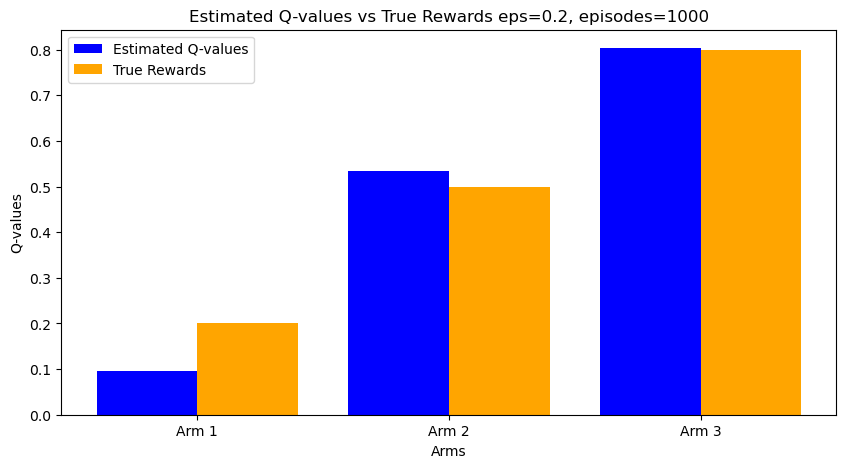

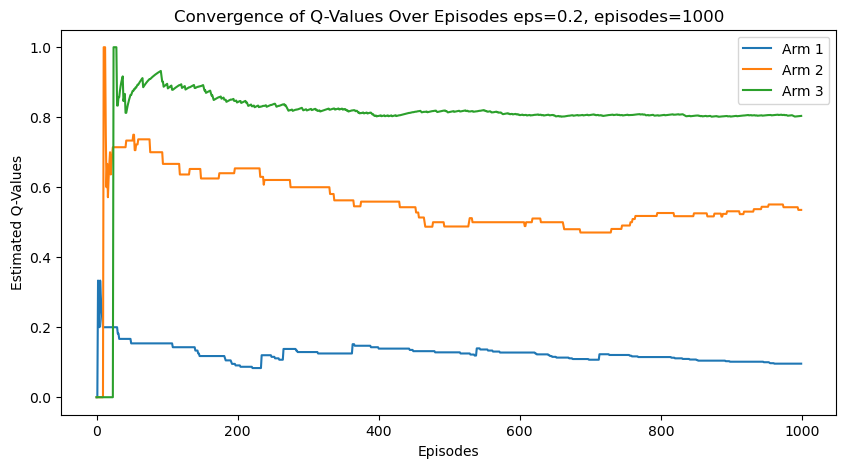


One Training Using Parameters {'true_rewards': [0.2, 0.5, 0.8], 'num_episodes': 1000, 'epsilon': 0.1}

Final Estimated Q-values after 1000 episodes: [0.20454545 0.40625    0.80952381]
True Q values: [0.2, 0.5, 0.8]
Best arm according to Monte Carlo estimation: Arm 3
True best arm: Arm 3
Potential Total Reward: 800.0
Yielded Total Reward: 764.0
Percentage of potential reward yielded: 95.50%


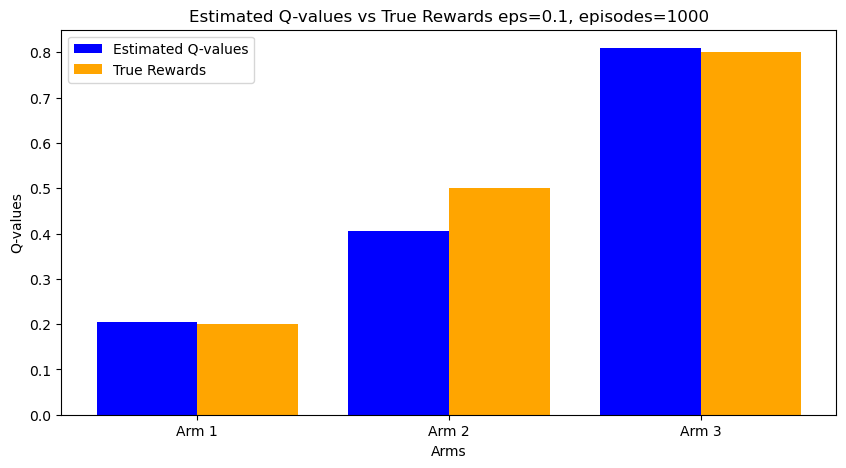

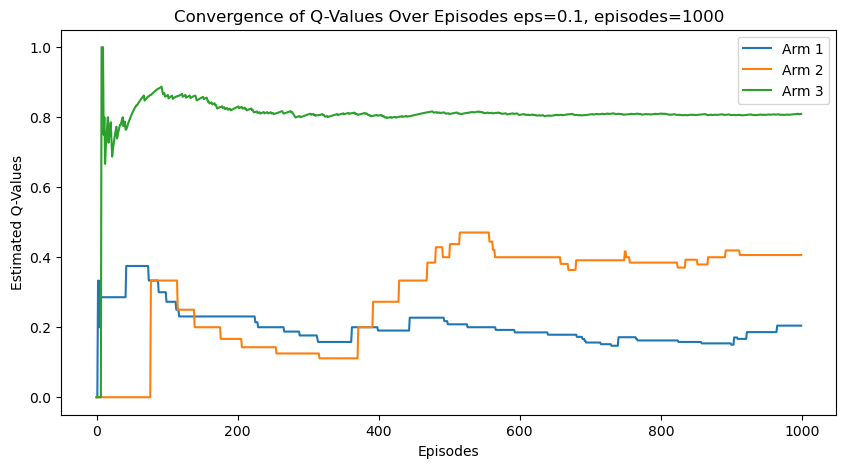


One Training Using Parameters {'true_rewards': [0.2, 0.5, 0.8], 'num_episodes': 1000, 'epsilon': 0.02}

Final Estimated Q-values after 1000 episodes: [0.21212121 0.7        0.80519481]
True Q values: [0.2, 0.5, 0.8]
Best arm according to Monte Carlo estimation: Arm 3
True best arm: Arm 3
Potential Total Reward: 800.0
Yielded Total Reward: 757.4000000000001
Percentage of potential reward yielded: 94.68%


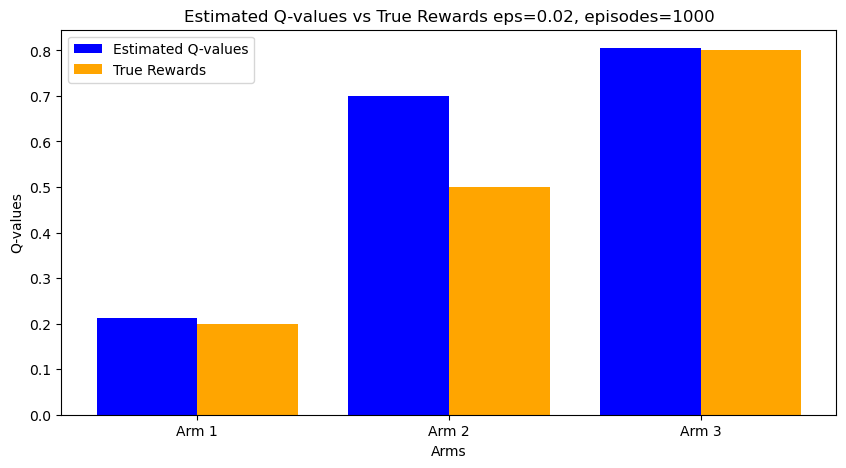

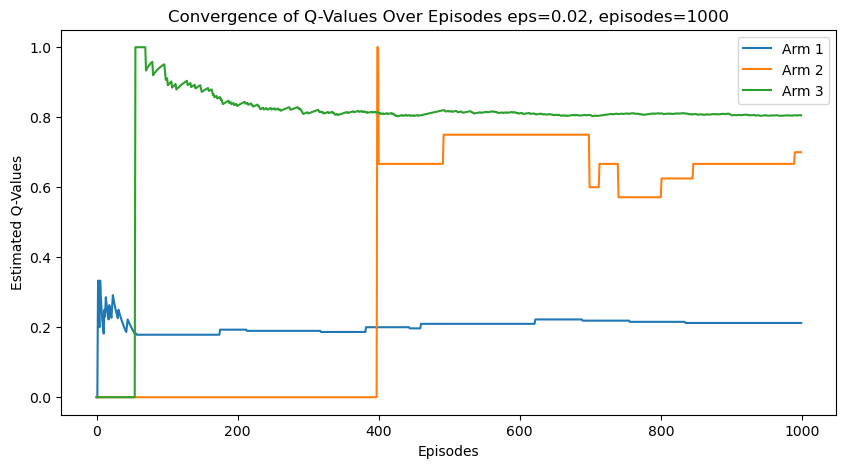

In [ ]:
for params in grid:
    true_rewards, num_episodes, epsilon = (
        params["true_rewards"],
        params["num_episodes"],
        params["epsilon"],
    )
    Q, Q_history, chosen = monte_carlo_ep_greedy(**params, random_state=42)
    print(f"\nOne Training Using Parameters {params}\n")
    final_estimates(
        Q,
        true_rewards=true_rewards,
        num_episodes=num_episodes,
        chosen=chosen,
        do_print=True,
    )
    plot_final_estimates(
        Q, 
        true_rewards=true_rewards, 
        text=f"eps={epsilon}, episodes={num_episodes}"
    )
    plot_q_convergence(
        Q_history, 
        text=f"eps={epsilon}, 
        episodes={num_episodes}"
    )

The ridges in the non-winning arms become wider as the epsilon value decreases: this is because their q-estimate proportions are adjusted less often after the dominant arm is established: only when an exploration action is made.

### b) Average 1,000 trainings to see which parameters perform the best in i) yielding the maximum reward and ii) selecting the correct best arm

In [32]:
for params in grid:
    results = []
    for i in range(1000):
        true_rewards, num_episodes, epsilon = (
            params["true_rewards"],
            params["num_episodes"],
            params["epsilon"],
        )
        Q, Q_history, chosen = monte_carlo_ep_greedy(
            **params,
            random_state=i
        )
        results.append(
            final_estimates(
                Q,
                true_rewards=true_rewards,
                num_episodes=num_episodes,
                chosen=chosen,
                do_print=False,
            )
        )
    # Average all three categories in the results list of dictionaries
    mean_mse = sum(result["mse"] for result in results) / len(results)
    p_correct_arm = sum(
        result["correct_best_arm"] for result in results
    ) / len(results)
    mean_yield = sum(
        result["yielded_reward_pct"] for result in results
    ) / len(results)

    print(f"\nAveraged Results Using Parameters {params}\n")
    print(f"Mean MSE: {mean_mse:.4f}")
    print(f"Proportion of Correct Best Arm: {p_correct_arm * 100:.2f}%")
    print(f"Mean Yielded Reward Percent: {mean_yield * 100:.2f}%")


Averaged Results Using Parameters {'true_rewards': [0.2, 0.5, 0.8], 'num_episodes': 1000, 'epsilon': 0.2}

Mean MSE: 0.0019
Proportion of Correct Best Arm: 100.00%
Mean Yielded Reward Percent: 91.39%

Averaged Results Using Parameters {'true_rewards': [0.2, 0.5, 0.8], 'num_episodes': 1000, 'epsilon': 0.1}

Mean MSE: 0.0033
Proportion of Correct Best Arm: 100.00%
Mean Yielded Reward Percent: 93.75%

Averaged Results Using Parameters {'true_rewards': [0.2, 0.5, 0.8], 'num_episodes': 1000, 'epsilon': 0.02}

Mean MSE: 0.0118
Proportion of Correct Best Arm: 97.70%
Mean Yielded Reward Percent: 87.38%


As it appears, even though epsilon=0.2 finds the correct arm faster, the leaning towards "explore" in the explore-exploit tradeoff throughout the training means it gains less overall yield. The least overall yield was from epsilon=0.02, likely because it took so long to find the correct arm, sticking with almost arbitrary ones for a while at the beginning, even though a lower explore amount meant spending more time on the correct arm once it found it. epsilon=0.1 struck a balance and obtained the most reward in this case. This example illustrates the importance of epsilon-decay, so options can be explored at the beginning and the model can stay decisive soon after.

# Question 2
### How do different slot machine distributions affect a Monte-Carlo agents' ability to yield maximum reward?

Let's use epsilon=0.1 and 1000 episodes with different slot machine distributions, and see which distribution is the "hardest" to optimize for the agent.

My guess is that more equal slot machine distributions will be harder to optimize for the agent because there will be a higher likelihood of misestablishment of the best slot machine early on. However, one might argue the opposite because there is less variance in the winning return between slot machines: lower stakes if you choose the wrong one.

I think it's likely though that the true answer for which of the distributions is the "hardest" depends on the epsilon value you're using. However, I will put off testing that for another time.

In [24]:
params_4 = {
    'true_rewards' : [0.2, 0.5, 0.8],
    'num_episodes': 1000,
    'epsilon': 0.1,
}
params_5 = {
    'true_rewards': [0.3, 0.5, 0.7],
    'num_episodes': 1000,
    'epsilon': 0.1,
}
params_6 = {
    'true_rewards': [0.4, 0.5, 0.6],
    'num_episodes': 1000,
    'epsilon': 0.1,
}
grid_2 = [params_4, params_5, params_6]

Plots of one training from each param set:


One Training Using Parameters {'true_rewards': [0.2, 0.5, 0.8], 'num_episodes': 1000, 'epsilon': 0.1}

Final Estimated Q-values after 1000 episodes: [0.23404255 0.5        0.80968097]
True Q values: [0.2, 0.5, 0.8]
Best arm according to Monte Carlo estimation: Arm 3
True best arm: Arm 3
Potential Total Reward: 800.0
Yielded Total Reward: 758.6
Percentage of potential reward yielded: 94.83%


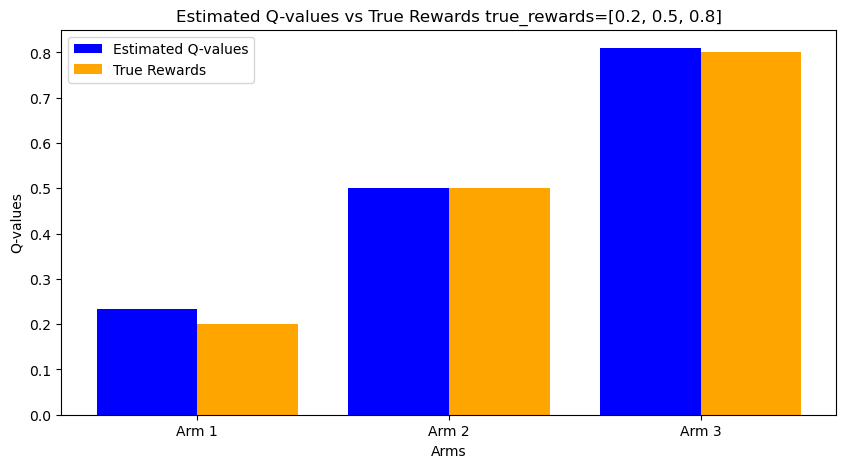

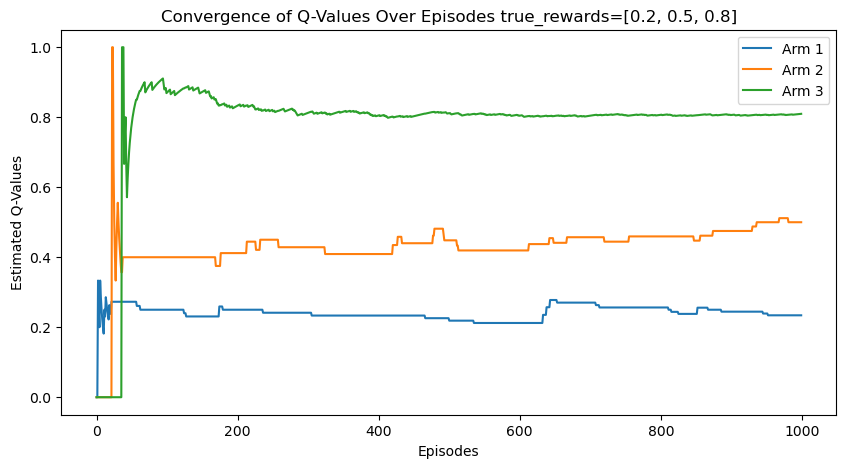


One Training Using Parameters {'true_rewards': [0.3, 0.5, 0.7], 'num_episodes': 1000, 'epsilon': 0.1}

Final Estimated Q-values after 1000 episodes: [0.16842105 0.5        0.79771429]
True Q values: [0.3, 0.5, 0.7]
Best arm according to Monte Carlo estimation: Arm 3
True best arm: Arm 3
Potential Total Reward: 700.0
Yielded Total Reward: 656.0
Percentage of potential reward yielded: 93.71%


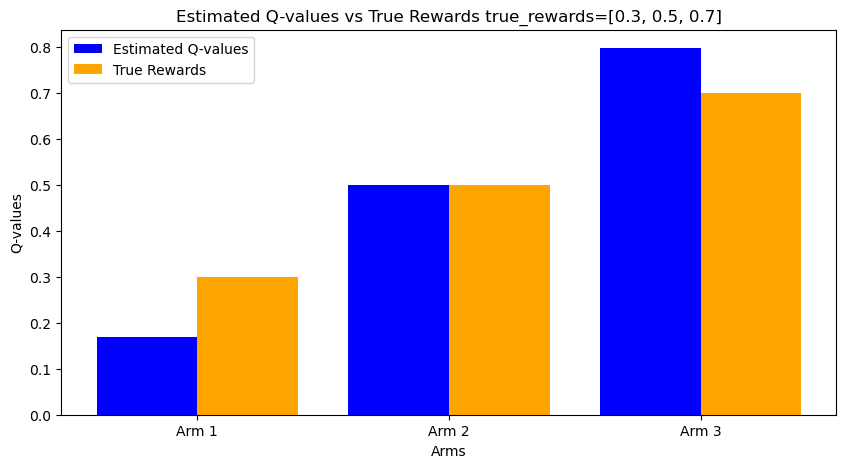

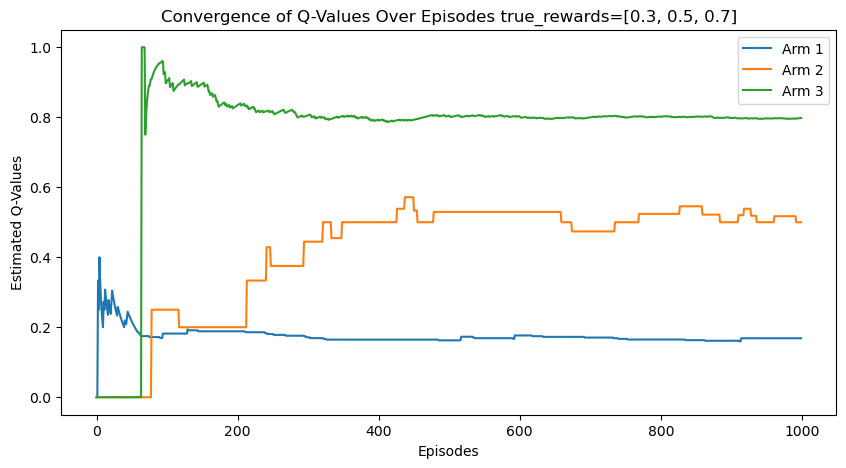


One Training Using Parameters {'true_rewards': [0.4, 0.5, 0.6], 'num_episodes': 1000, 'epsilon': 0.1}

Final Estimated Q-values after 1000 episodes: [0.19642857 0.38888889 0.80837004]
True Q values: [0.4, 0.5, 0.6]
Best arm according to Monte Carlo estimation: Arm 3
True best arm: Arm 3
Potential Total Reward: 600.0
Yielded Total Reward: 585.1999999999999
Percentage of potential reward yielded: 97.53%


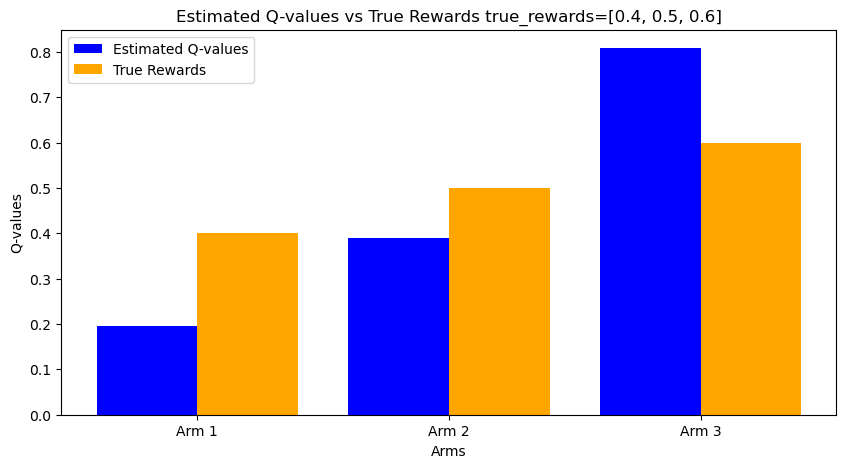

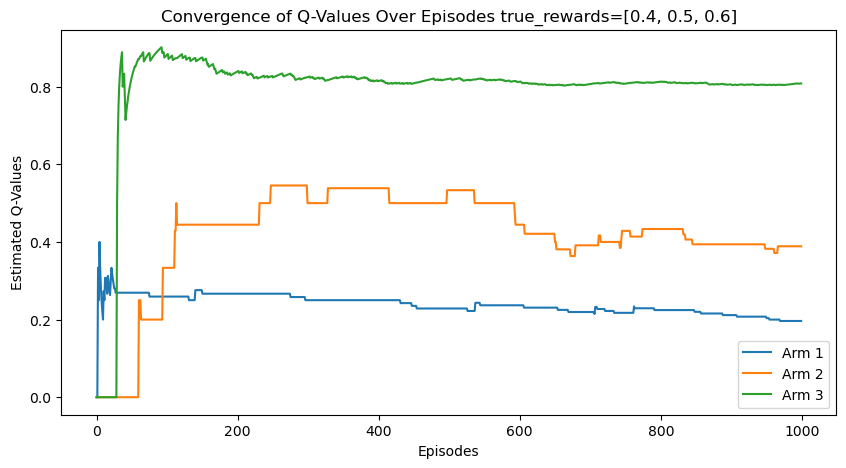

In [ ]:
for params in grid_2:
    true_rewards, num_episodes, epsilon = (
        params["true_rewards"],
        params["num_episodes"],
        params["epsilon"],
    )
    Q, Q_history, chosen = monte_carlo_ep_greedy(
        **params, random_state=42
    )
    print(f"\nOne Training Using Parameters {params}\n")
    final_estimates(
        Q,
        true_rewards=true_rewards,
        num_episodes=num_episodes,
        chosen=chosen,
        do_print=True,
    )
    plot_final_estimates(
        Q, 
        true_rewards=true_rewards, 
        text=f"true_rewards={true_rewards}"
    )
    plot_q_convergence(Q_history, text=f"true_rewards={true_rewards}")

Averaged over 1000 runs:

In [ ]:
for params in grid_2:
    results = []
    for i in range(1000):
        true_rewards, num_episodes, epsilon = (
            params["true_rewards"],
            params["num_episodes"],
            params["epsilon"],
        )
        Q, Q_history, chosen = monte_carlo_ep_greedy(**params, random_state=i)
        results.append(
            final_estimates(
                Q,
                true_rewards=true_rewards,
                num_episodes=num_episodes,
                chosen=chosen,
                do_print=False,
            )
        )
    # Average all three categories in the results list of dictionaries
    mean_mse = sum(
        result["mse"] for result in results
    ) / len(results)
    p_correct_arm = sum(
        result["correct_best_arm"] for result in results
    ) / len(results)
    mean_yield = sum(
        result["yielded_reward_pct"] for result in results
    ) / len(results)

    print(f"\nAveraged Results Using Parameters {params}\n")
    print(f"Mean MSE: {mean_mse:.4f}")
    print(f"Proportion of Correct Best Arm: {p_correct_arm * 100:.2f}%")
    print(f"Mean Yielded Reward Percent: {mean_yield * 100:.2f}%")


Averaged Results Using Parameters {'true_rewards': [0.2, 0.5, 0.8], 'num_episodes': 1000, 'epsilon': 0.1}

Mean MSE: 0.0032
Proportion of Correct Best Arm: 100.00 %
Mean Yielded Reward Percent: 93.77 %

Averaged Results Using Parameters {'true_rewards': [0.3, 0.5, 0.7], 'num_episodes': 1000, 'epsilon': 0.1}

Mean MSE: 0.0098
Proportion of Correct Best Arm: 100.00 %
Mean Yielded Reward Percent: 95.34 %

Averaged Results Using Parameters {'true_rewards': [0.4, 0.5, 0.6], 'num_episodes': 1000, 'epsilon': 0.1}

Mean MSE: 0.0299
Proportion of Correct Best Arm: 100.00 %
Mean Yielded Reward Percent: 97.27 %


In this case, my guess was wrong! The lowest yielded percent, or the "hardest" for the agent to learn in this case was for the probabilities 20%, 50%, and 80%.

In future work, I'll grid search the epsilon value for slot machine set, and choose the best epsilon value, which will reveal which is the "truly hardest".

Additionally, it would be interesting to try other explore-exploit algorithms such as allocating the first few episodes to exploring and the rest to exploiting. That would probably be more effective in this problem, but would not pertain to more advanced Q-learning problems that require exploring throughout.